In [1]:
import sys
import os
# Adding the path to the marcia package
sys.path.append(os.path.abspath('../../'))

import numpy as np 
import scipy as sp
import h5py


# Importing the marcia package
%load_ext autoreload
%autoreload 2
from marcia import Kernel
from marcia import Cosmology
from marcia import Data
from marcia import params

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# To-Do list:
# 1. install pycamb or class integration
# 2. To adopt the data module to the CMB data loading better !!
# 3. Include the cosmology mean function
# 4. include the ACT dataset and mean 
# 5. We can later reconstruct the signal based on this model independent reconstructed covariance matrix

In [27]:
# set data
data_list = ['Planck_TT','Planck_EE','Planck_TE']
# data_list = ['Planck_TE']
d = Data(data_list)

Nuisance parameters are set to default values


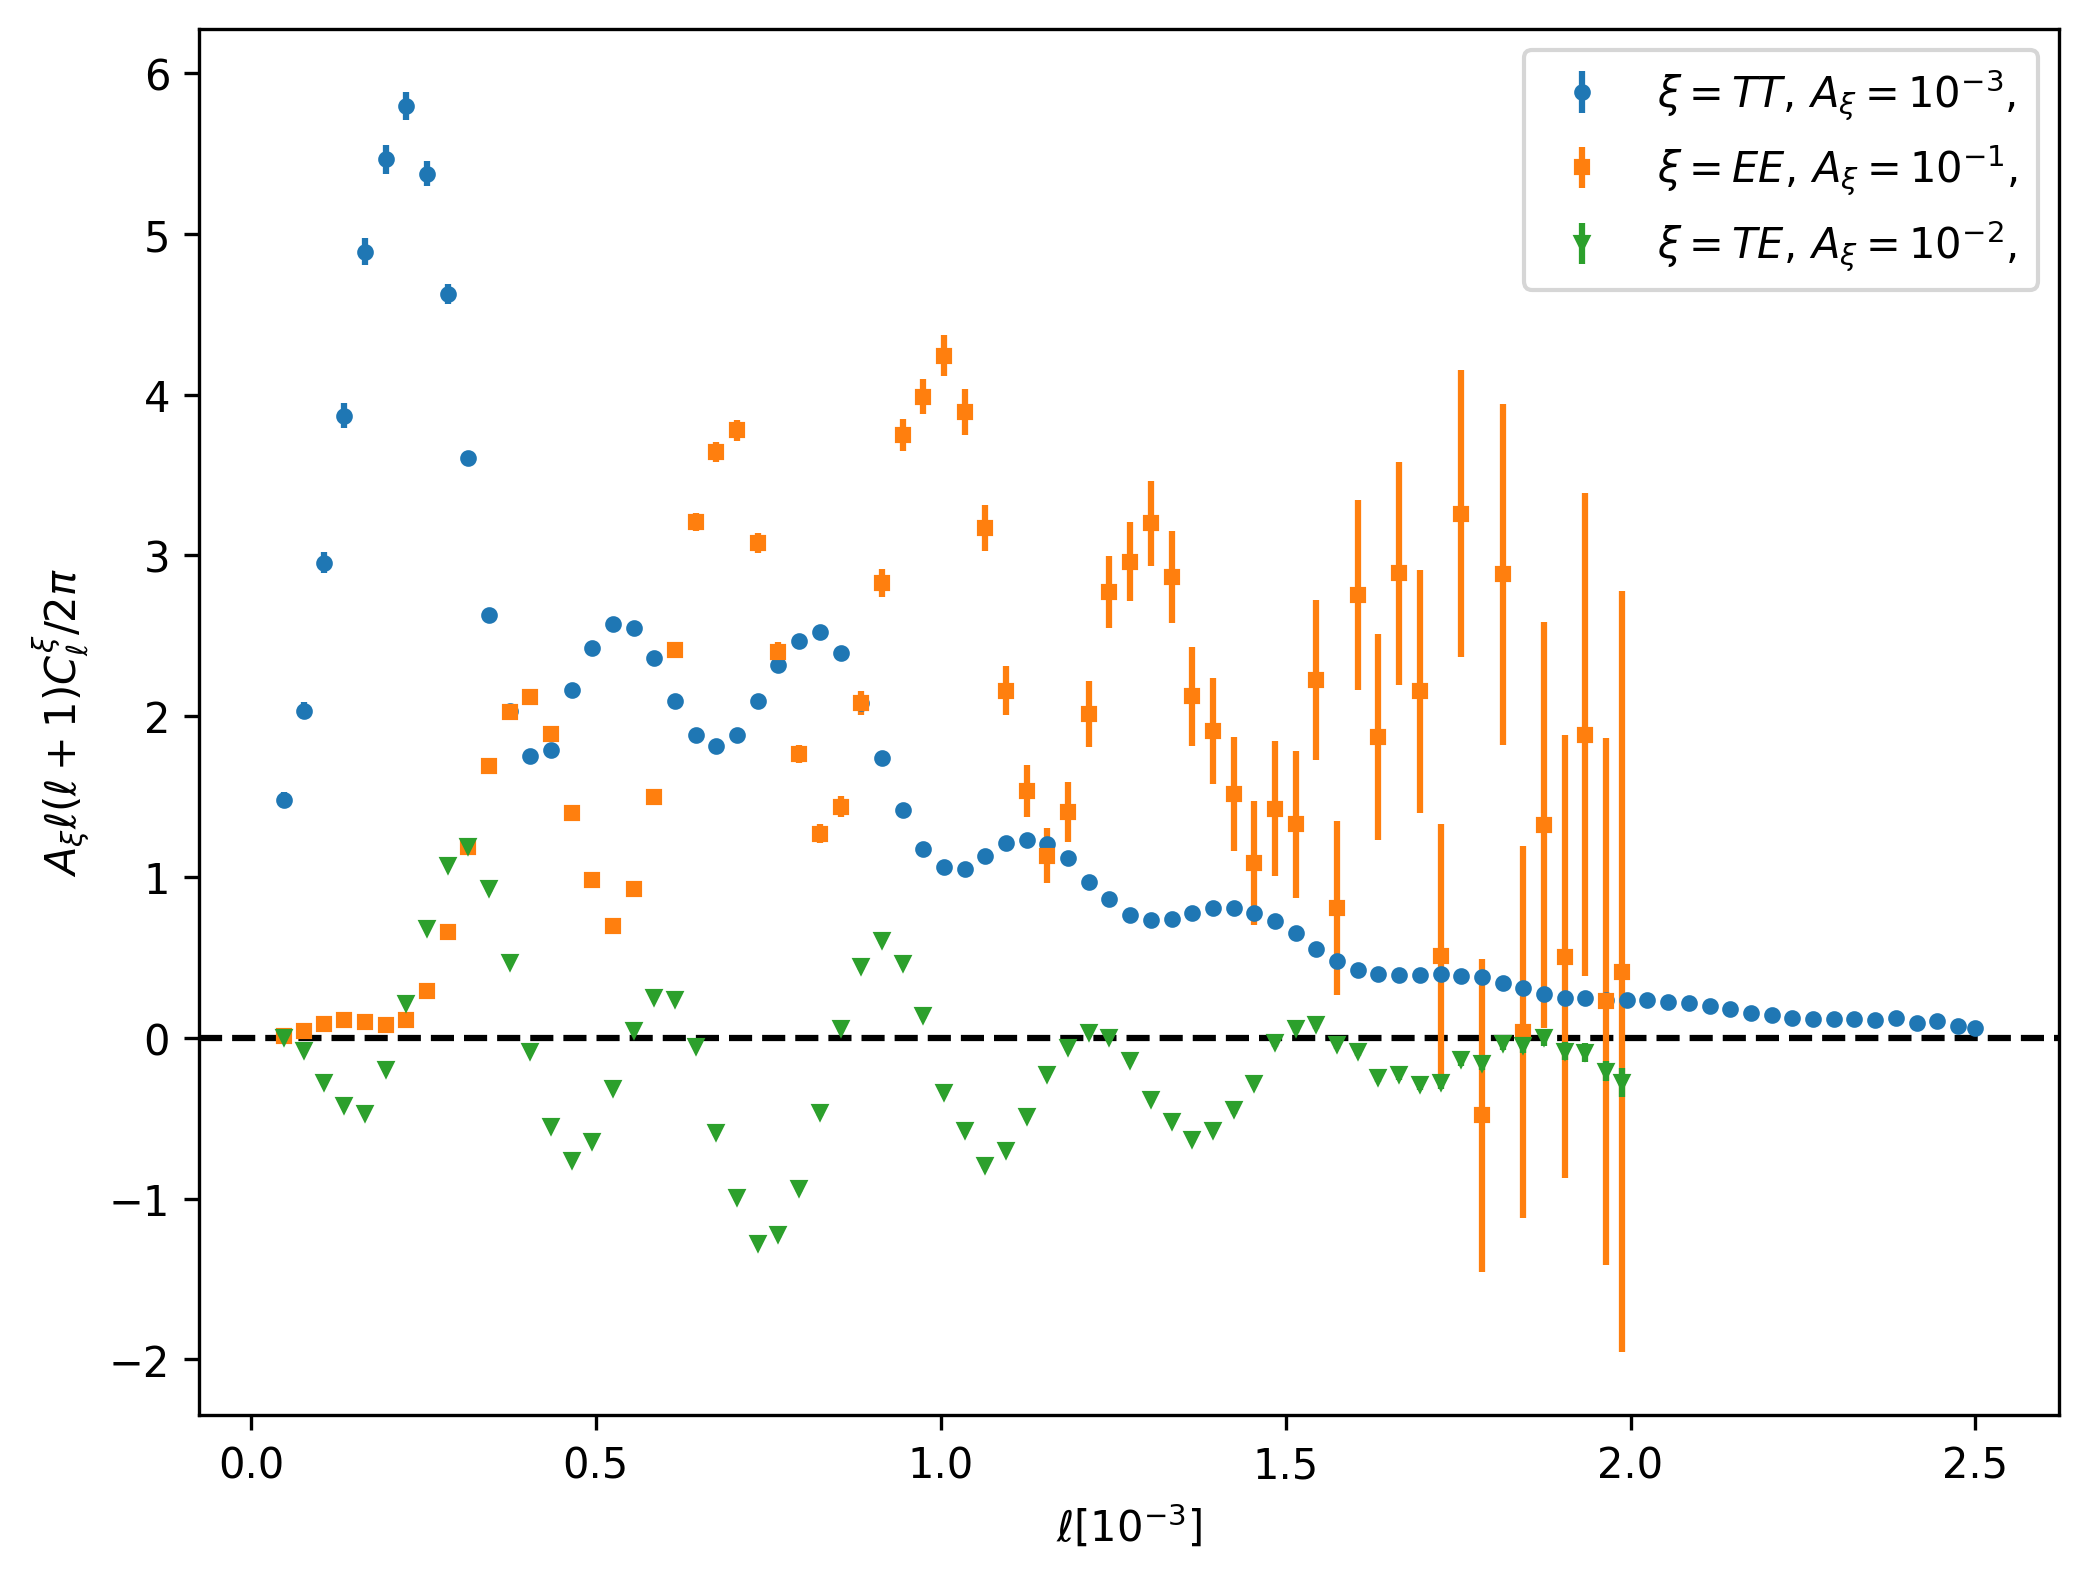

In [28]:
fig = plt.figure(figsize=(8,6), dpi = 300)
plt.xlabel(r'$\ell [10^{-3}]$')
plt.ylabel(r'$A_{\xi}\ell(\ell+1)C_\ell^{\xi}/2\pi$')
plt.axhline(0,color='k',ls='--')

x,y, cov = d()
# To plot teh three data sets in the same panel after some rescaling of the data in teh y axis
plt.errorbar(d.x['x0'],d.y['y0'],yerr=np.sqrt(np.diag(d.covar['covar0'])),fmt='o', markersize = 3, label=r'$\xi = TT, \, A_{\xi } = 10^{-3}$, ')
plt.errorbar(d.x['x1'],d.y['y1'],yerr=np.sqrt(np.diag(d.covar['covar1'])),fmt='s', markersize = 3, label=r'$\xi = EE, \, A_{\xi } = 10^{-1}$, ')
plt.errorbar(d.x['x2'],d.y['y2'],yerr=np.sqrt(np.diag(d.covar['covar2'])),fmt='v', markersize = 3, label=r'$\xi = TE, \, A_{\xi } = 10^{-2}$, ')


plt.gca().legend(loc='upper right',fontsize=10)


In [57]:
data_ker = list(d.x.values())
filename = os.path.join(os.getcwd(),'GPconfig_CMB.ini')
K = Kernel(data_ker, filename = filename)

Loading the config file from /home/sandeep/Projects/marcia/Notebooks/CMB/GPconfig_CMB.ini ... 
Number of tasks: 3
Number of datasets: 3
Kernels: ['SE', 'SE', 'SE']
Perfroming a multi task Gaussian process regression using SE kernels and 3 tasks


In [60]:
import emcee 
%load_ext autoreload
%autoreload 2
from marcia import Likelihood_GP as lk

log_prob = lk(data = data_list, GP_filename = filename)

def logProb(theta):
    return log_prob.logProb(theta)

# Set the dimensionality of the problem
ndim = 2*len(data_list)
# Set the number of walkers. It has to be an even number
nwalkers = 200
# Set the number of iterations
niterations = 2000
# Set the number of burnin iterations
nburnin = 100

# Set the initial position of the walkers based on the priors from the GPconfig file
log_prob.priors
print(log_prob.priors)
# set the initial position of the walkers based on the priors from the GPconfig file
pos = np.transpose([np.random.uniform(log_prob.priors[i][0], log_prob.priors[i][1], nwalkers) for i in range(ndim)])

# Set the backend
outpath = 'Chains/'+ '_'.join(data_list) + '_chain.h5'
backend = emcee.backends.HDFBackend(outpath)

# Set the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, logProb, backend=backend)

# Run the production chain
print("Running production...")
sampler.run_mcmc(pos, niterations, rstate0=pos, progress=True);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Nuisance parameters are set to default values
Loading the config file from /home/sandeep/Projects/marcia/Notebooks/CMB/GPconfig_CMB.ini ... 
Number of tasks: 3
Number of datasets: 3
Kernels: ['SE', 'SE', 'SE']
Perfroming a multi task Gaussian process regression using SE kernels and 3 tasks
[[0.5  5.  ]
 [0.01 0.2 ]
 [0.5  5.  ]
 [0.01 0.2 ]
 [0.5  5.  ]
 [0.01 0.2 ]]
Running production...


100%|██████████| 2000/2000 [15:26<00:00,  2.16it/s]


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


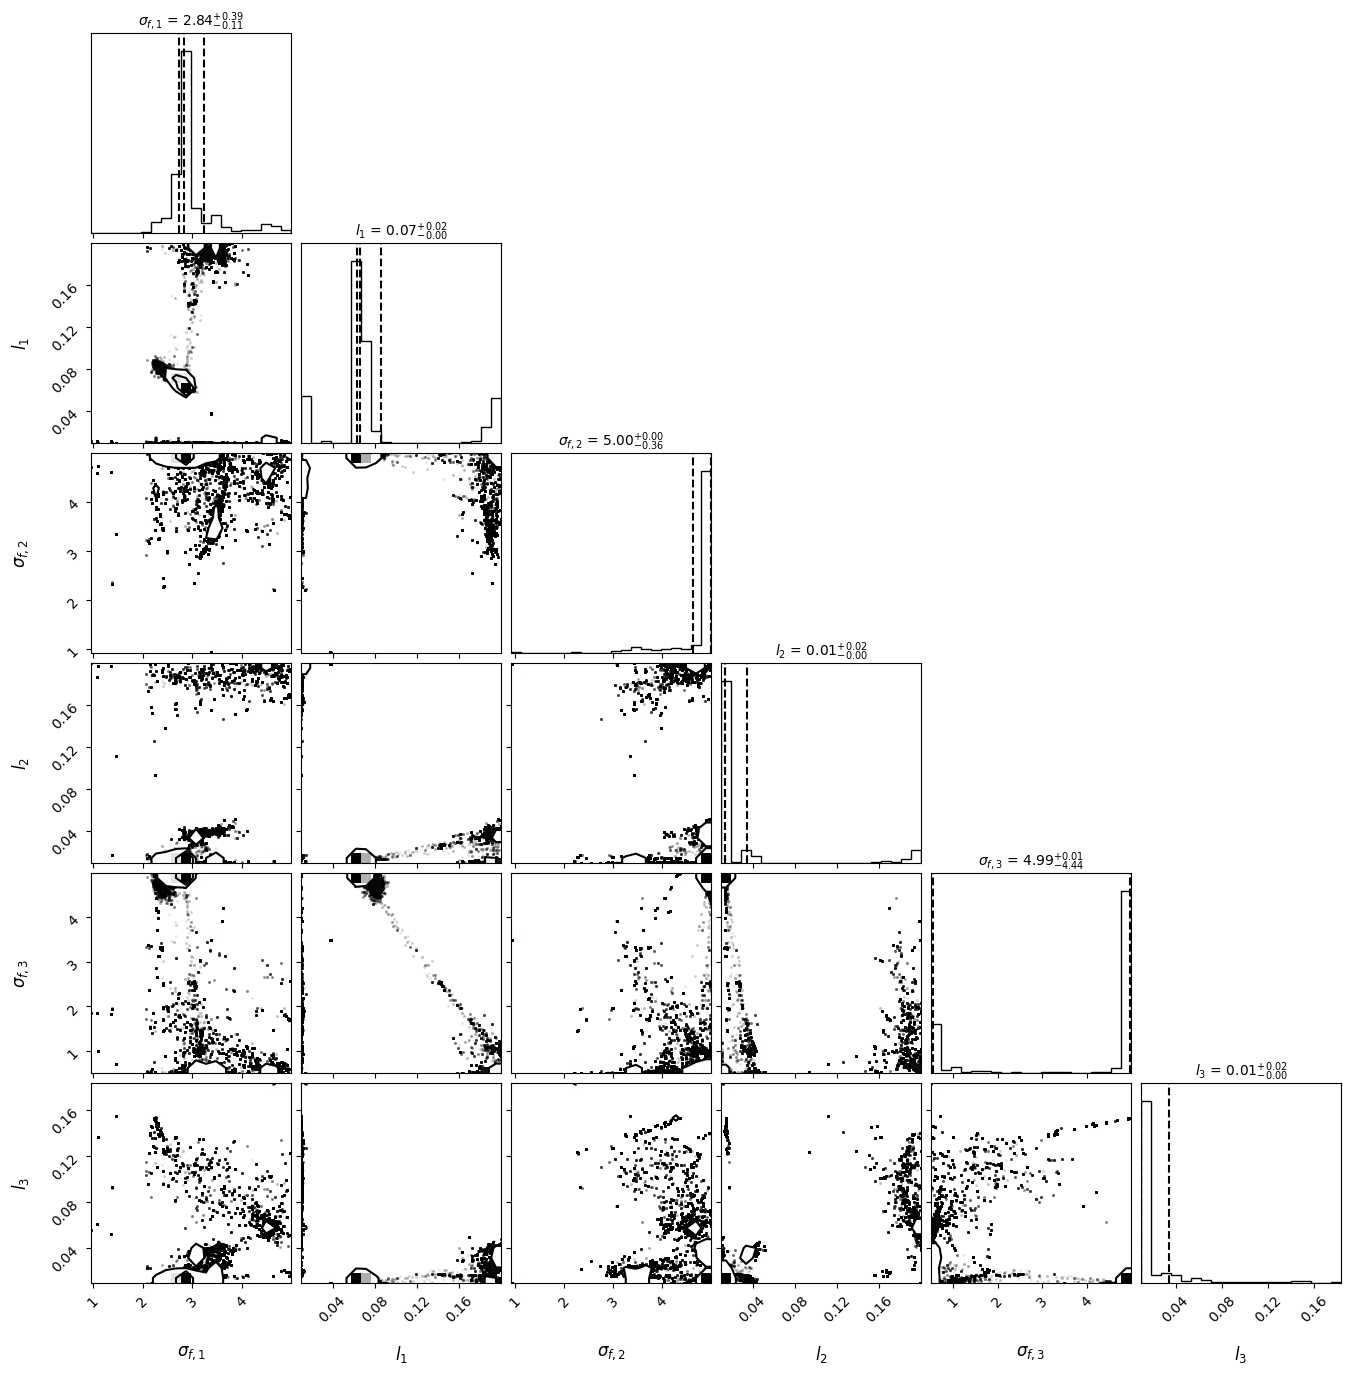

In [61]:
import corner
samples = sampler.get_chain(flat=True, discard=500)


# samples = [x for x in samples and x[0] > 0 and x[1]<40]  
fig = corner.corner(samples, labels=[r"$\sigma_{f,1}$", r"$l_1$", r"$\sigma_{f,2}$", r"$l_2$", r"$\sigma_{f,3}$", r"$l_3$"], quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 10}, label_kwargs={"fontsize": 12})
# plot single task 
# fig = corner.corner(samples, labels=[r"$\sigma_{f,1}$", r"$l_1$"], quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 10}, label_kwargs={"fontsize": 12})
plot_path = outpath = 'Chains/'+ '_'.join(data_list) + '_corner.png'
fig.savefig(plot_path, dpi=300, bbox_inches='tight')

In [20]:
import scipy.optimize as op

def MLE(verbose=True):
    nll = lambda x: -log_prob.logProb(x)
    result = op.minimize(nll, x0=pos, method = 'Nelder-Mead', options={'maxfev': None}, tol=1e-6)
    if verbose:
        print(f'Best-fit values: {result.x}')
        print(f'Max-Likelihood value (including prior likelihood):{log_prob.logProb(result.x)}')
    return result.x

In [21]:
for i in range(3):
    index = np.random.randint(0, len(samples))
    pos = samples[index]
    MLE()
a = MLE()

Best-fit values: [0.85378423 0.10951711]
Max-Likelihood value (including prior likelihood):66.13963012462001
Best-fit values: [0.85378424 0.10951711]
Max-Likelihood value (including prior likelihood):66.13963012461615
Best-fit values: [0.85378345 0.10951711]
Max-Likelihood value (including prior likelihood):66.139630124612
Best-fit values: [0.85378345 0.10951711]
Max-Likelihood value (including prior likelihood):66.139630124612


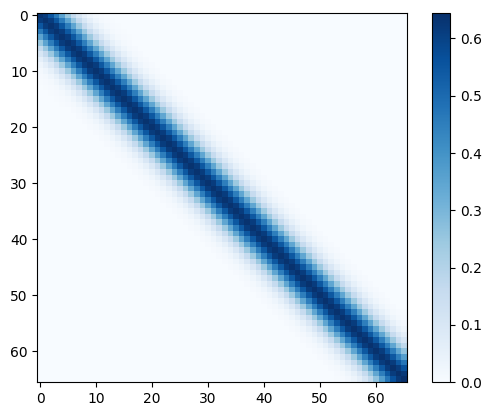

In [22]:
plt.imshow(log_prob.GP_kernels.Cov_Mat([pos]) + log_prob.D_covmat, cmap='Blues')
plt.colorbar()

In [23]:
from marcia import kernel as kern
kerns = kern.Kernel(list(d.x.values()), filename=filename)
xstar = np.linspace(0, 3, 1000)
# make predictions at the test points
covmat_star = kerns.kernel('SE', a, xstar, d.x['x0'])
covmat_star_star = kerns.kernel('SE', a, xstar, xstar)

# make predictions at the test points


Loading the config file from /home/sandeep/Projects/marcia/Notebooks/CMB/GPconfig_CMB_TT.ini ... 
Number of tasks: 1
Number of datasets: 1
Kernels: ['SE']
Perfroming a simple Gaussian process regression for a single task using SE kernel


In [24]:
params = log_prob.set_theta(a)
covmat = log_prob.GP_kernels.Cov_Mat(params) + log_prob.D_covmat + 1e-6*np.eye(len(log_prob.D_covmat))

cov_mat_inv = np.linalg.inv(covmat)


fmean = np.dot(covmat_star, np.dot(cov_mat_inv, log_prob.y - log_prob.mean))
fcov = np.sqrt(np.diag(covmat_star_star - np.dot(covmat_star, np.dot(cov_mat_inv, covmat_star.T))))
fstdev = np.diag(np.diag(np.sqrt(fcov)))

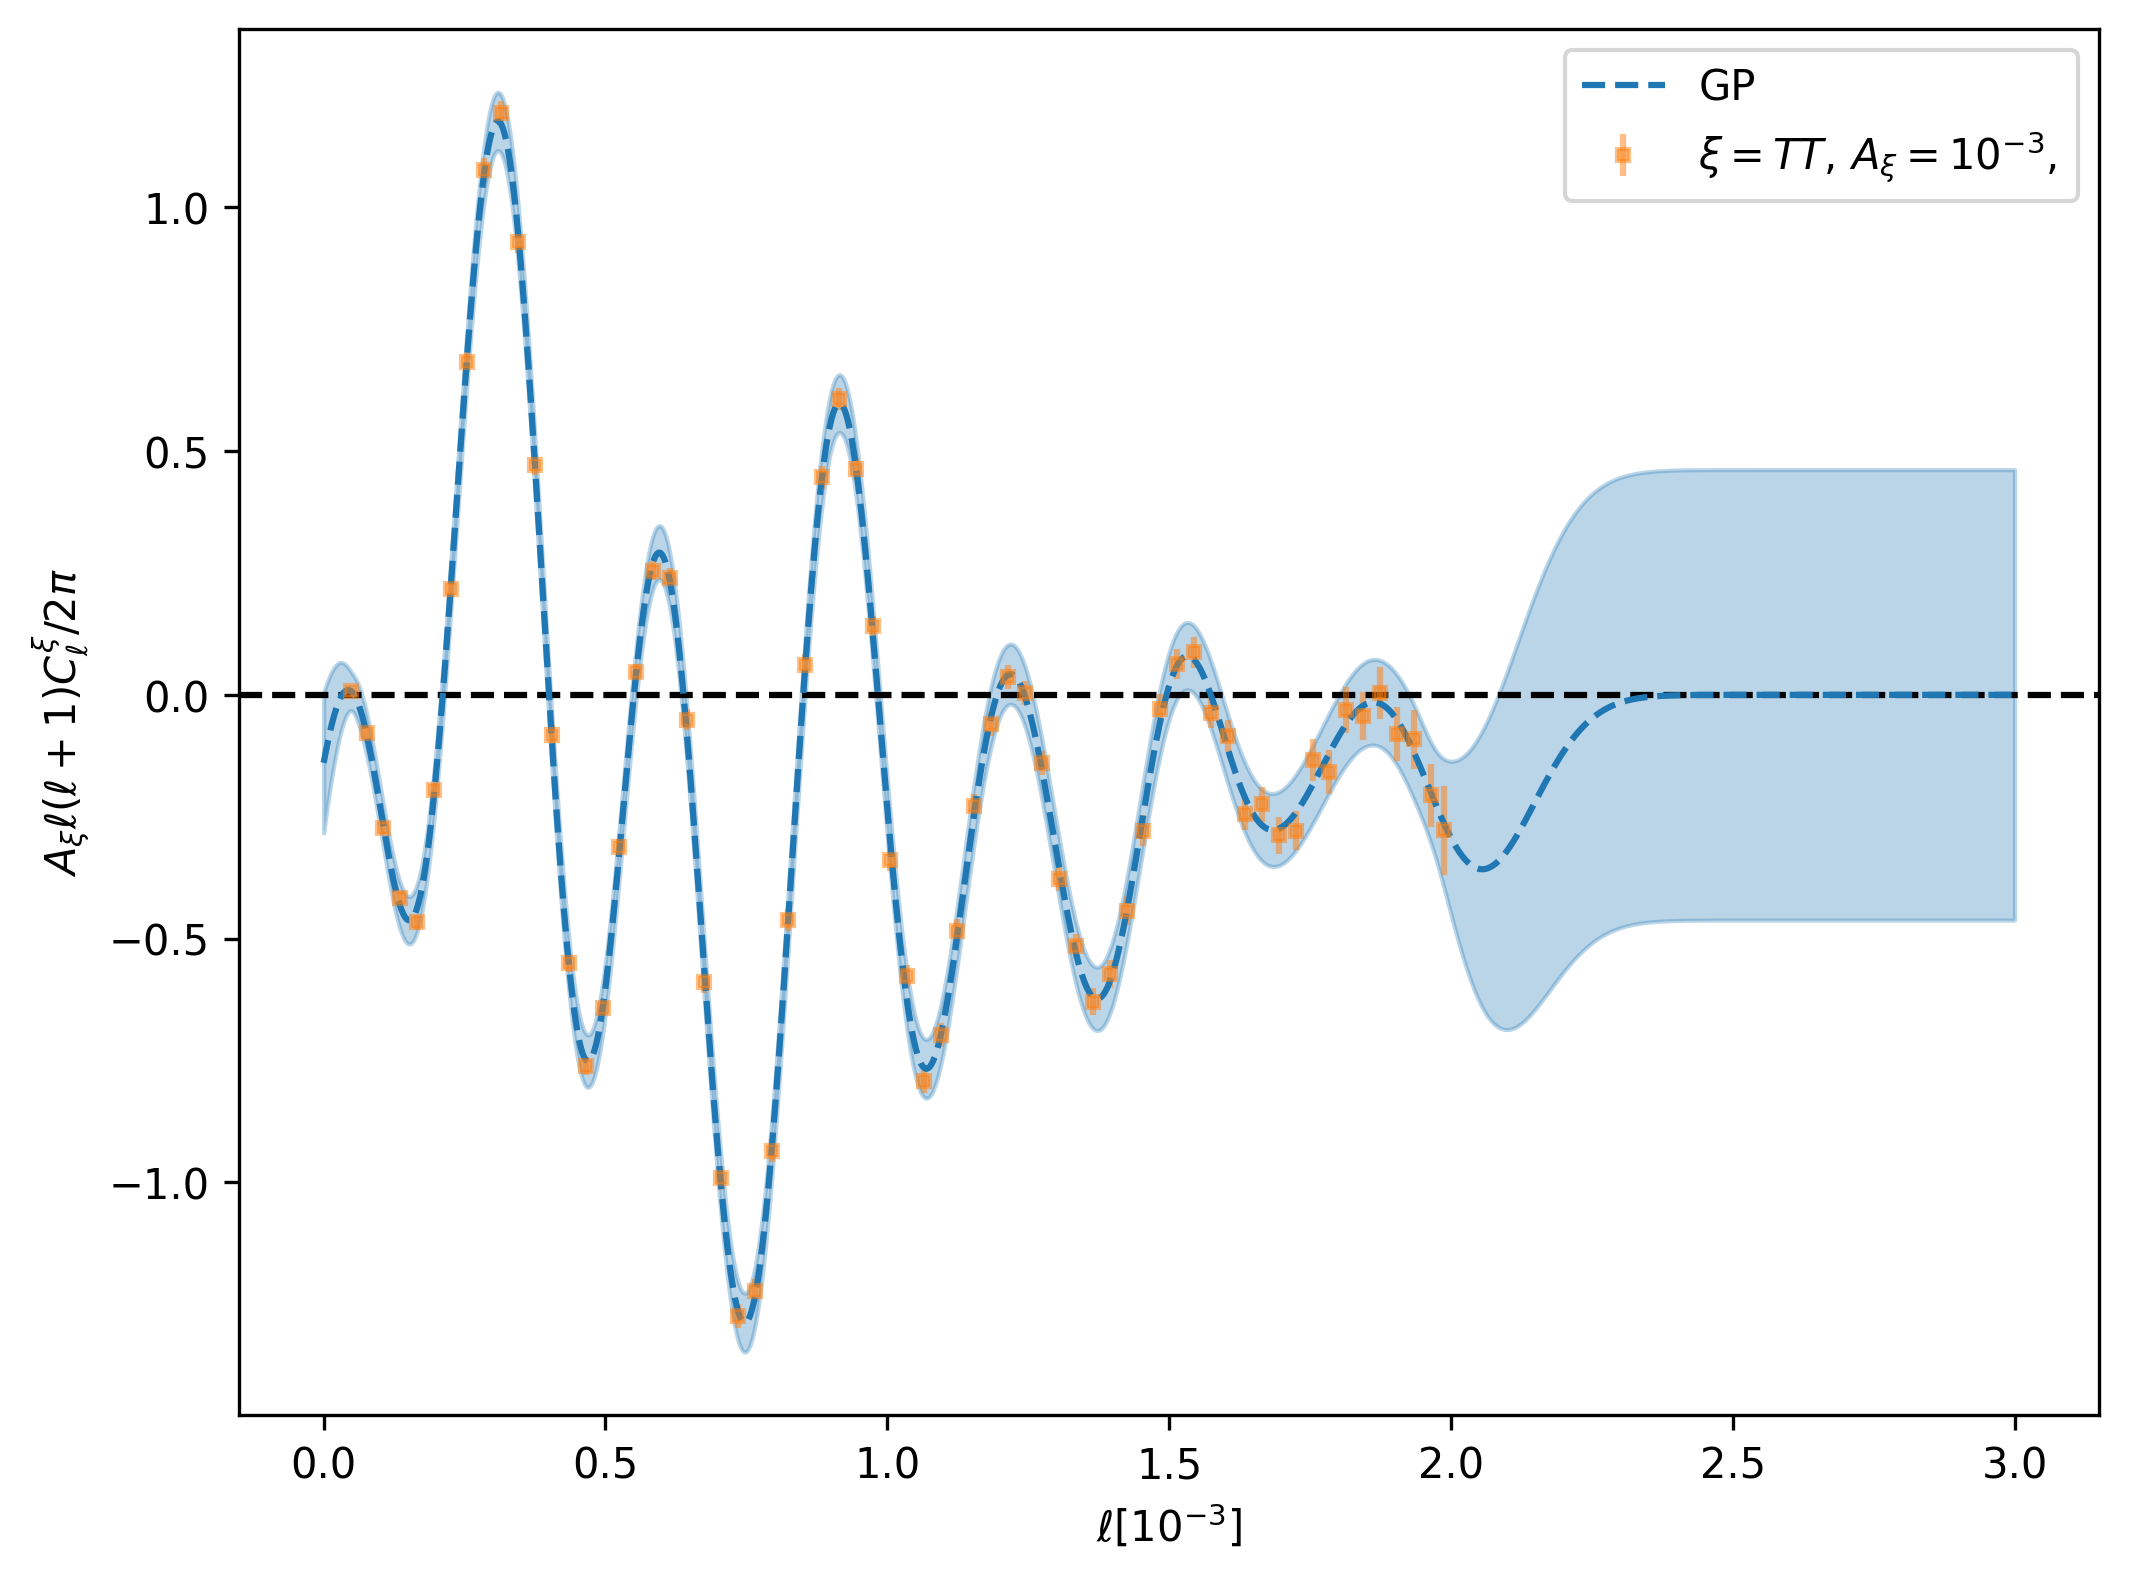

In [26]:
# plot the cmb data against the reconstructed curve from the GP
#   
fig = plt.figure(figsize=(8,6), dpi = 300)
plt.xlabel(r'$\ell [10^{-3}]$')
plt.ylabel(r'$A_{\xi}\ell(\ell+1)C_\ell^{\xi}/2\pi$')
plt.axhline(0,color='k',ls='--')

# To plot the data
plt.errorbar(d.x['x0'],d.y['y0'],yerr=np.sqrt(np.diag(d.covar['covar0'])),fmt='s', markersize = 3, label=r'$\xi = TT, \, A_{\xi } = 10^{-3}$, ', alpha = 0.5, color = 'tab:orange')

# To plot the GP curve
plt.plot(xstar, fmean, color='tab:blue', label='GP', ls = '--')
plt.fill_between(xstar, fmean - fstdev/2.0, fmean + fstdev/2.0, alpha=0.3, color='tab:blue')  
plt.gca().legend(loc='upper right', fontsize = 10)

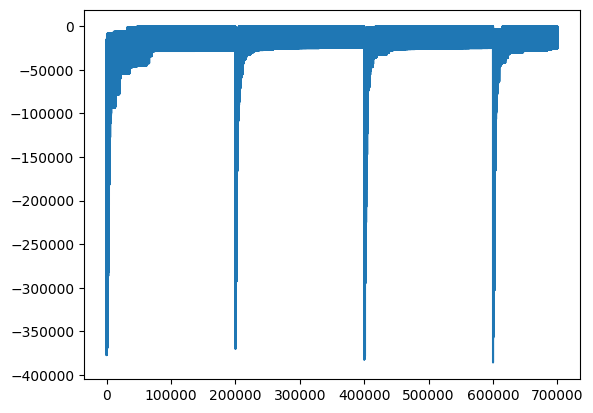

In [14]:
plt.plot(sampler.flatlnprobability)